# Smoothing Investigation
## June 2023


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

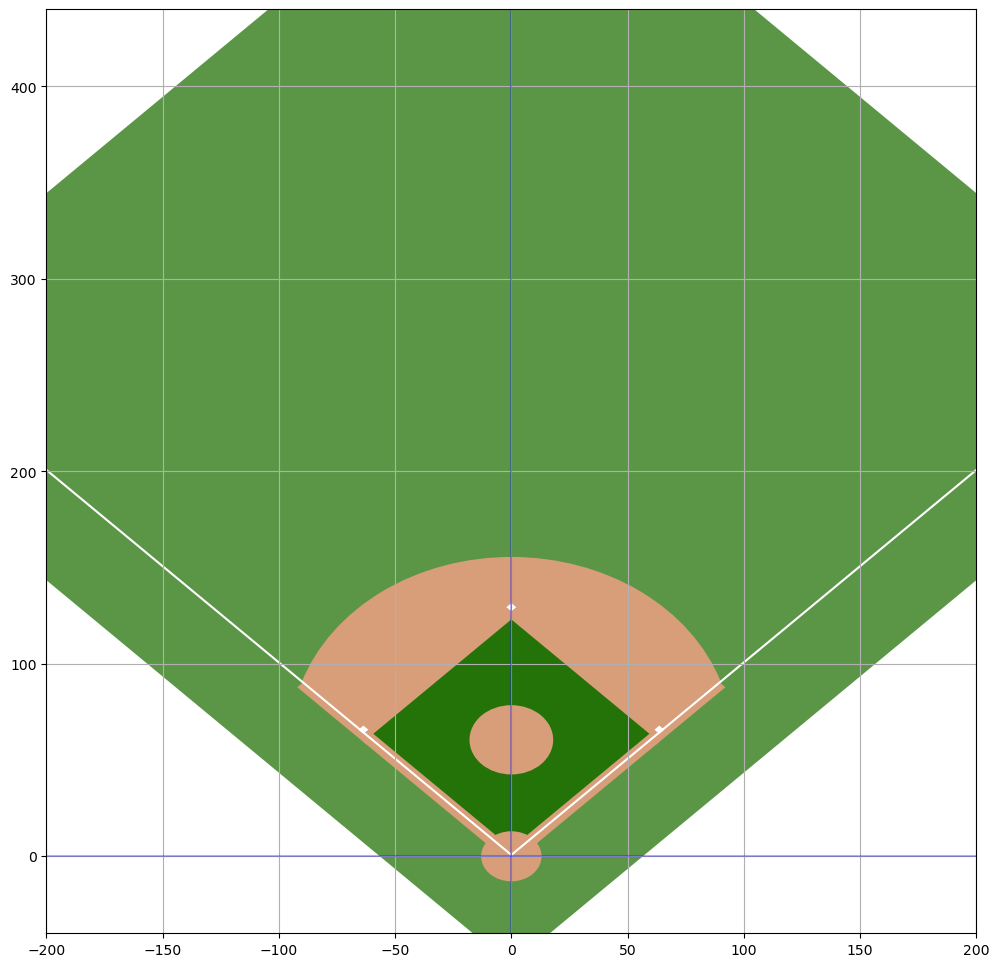

In [3]:
bf = Baseball_Field(which_game="1903_01_TeamNE_TeamA2")

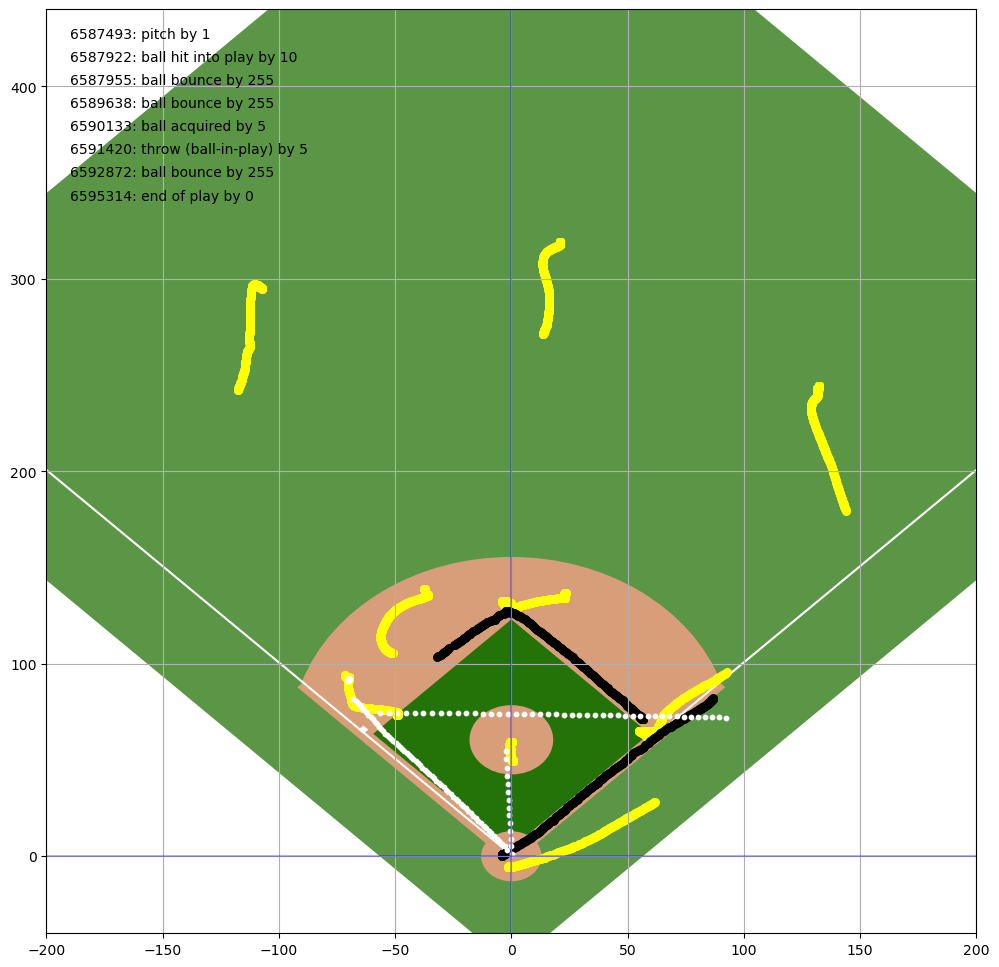

In [4]:
bf.plot_all_components(play_id=203)
bf.fig

### so far I have snapped the ball position to the fielder who acquired the ball

- In the below figure, you can see that the ball kind of jumps from left center to into the center fielders mitt
- I think this will be a problem if I want to compute velocities and whatnot

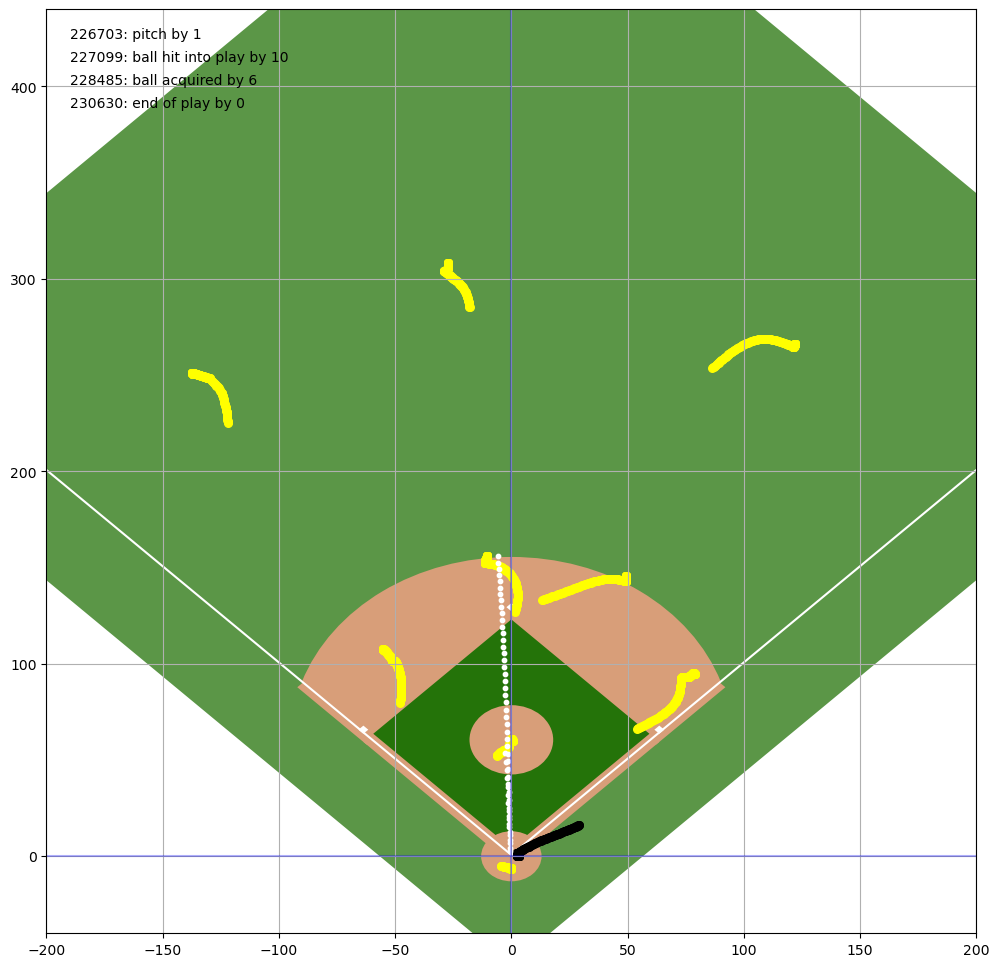

In [5]:
bf.clear_plot()

bf.plot_all_components(play_id=12)
bf.fig

#### See that same phenomenon here -- notice the discontinuities with the ball

In [6]:
ball_pos = bf.game_obj.new_ball_pos.copy()

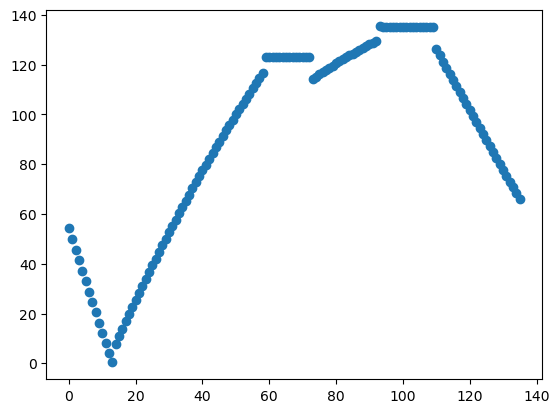

In [7]:
fig, ax = plt.subplots()

play_10_ball = ball_pos.loc[ball_pos["play_id"] == 10, :]

play_10_ball = play_10_ball.reset_index()
ax.plot(play_10_ball["ball_position_y"], 'o')
plt.show()

### I think this means I should smooth
- the question is what do I smooth? and how?

In [8]:
### A util function

def plot_xy_pos(play_id, player_pos_num, player_pos = None, ball_pos=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots()
    
    
    if player_pos is not None :
        this_play_player_pos = player_pos.loc[(player_pos["play_id"] == play_id) &
               (player_pos["player_position"] == player_pos_num)
                                          , :] 
    
        ax.scatter(this_play_player_pos["field_x"], this_play_player_pos["field_y"], 
                c = this_play_player_pos["timestamp"],
                cmap='jet'
               )

    if ball_pos is not None :
        this_play_ball_pos = ball_pos.loc[(ball_pos["play_id"] == play_id)
                                          , :] 
    
        ax.scatter(this_play_ball_pos["ball_position_x"], this_play_ball_pos["ball_position_y"], 
                c = this_play_ball_pos["timestamp"],
                cmap='jet'
               )
    
    #plt.show()
    return fig, ax
    

In [9]:
player_pos = bf.game_obj.player_pos_df.copy()
player_pos.head(3)

,game_str,play_id,timestamp,player_position,field_x,field_y
1,1903_01_TeamNE_TeamA2,1,19199,1,0.4377,59.9220
2,1903_01_TeamNE_TeamA2,1,19232,1,0.4410,59.9139
3,1903_01_TeamNE_TeamA2,1,19265,1,0.4446,59.9064


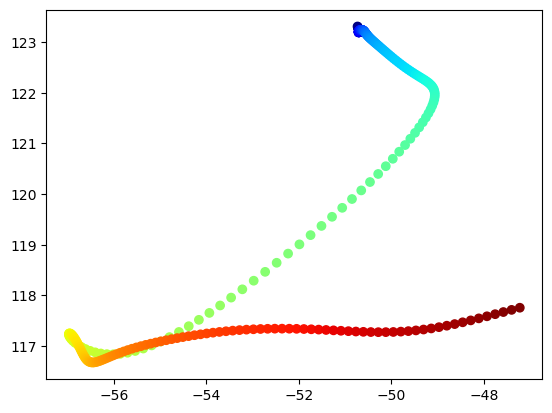

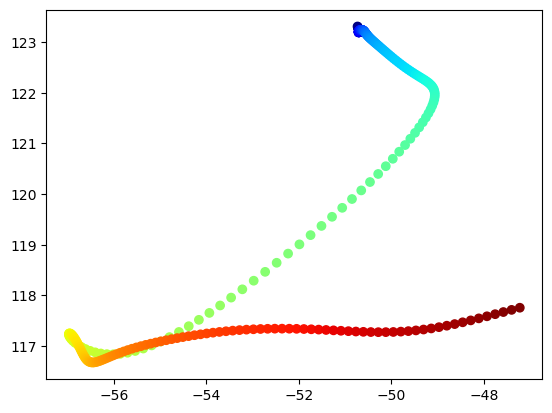

In [10]:
# the plot of the SS for play_id 10
f, a = plot_xy_pos(10, 6, player_pos=player_pos)
f

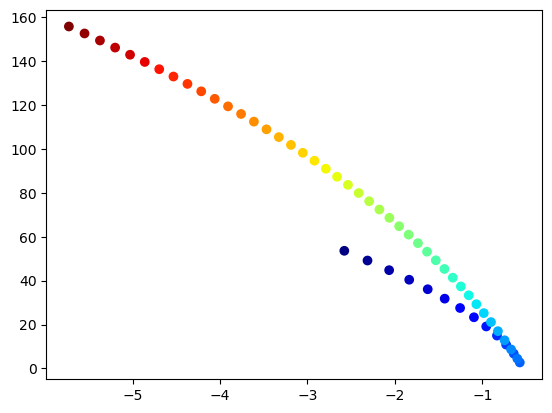

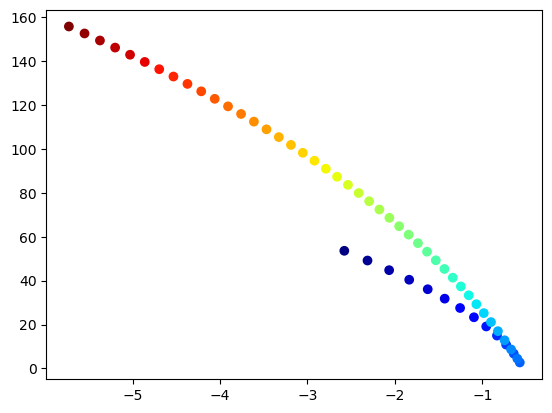

In [11]:
# the plot of the ball for play_id 10
# These weird discontinuities are where I filled in the data
f, a = plot_xy_pos(12, 6, ball_pos=ball_pos)
f

### What happens if I smooth players?

In [12]:
smoothed_player_pos = player_pos.copy()

smoothed_xy = player_pos.groupby(["play_id", "player_position"])[["field_x", "field_y"]]\
    .rolling(3, center=True, closed="both").mean()\
    .loc[:, ["field_x", "field_y"]]


smoothed_player_pos["smoothed_field_x"] = smoothed_xy["field_x"].values
smoothed_player_pos["smoothed_field_y"] = smoothed_xy["field_y"].values



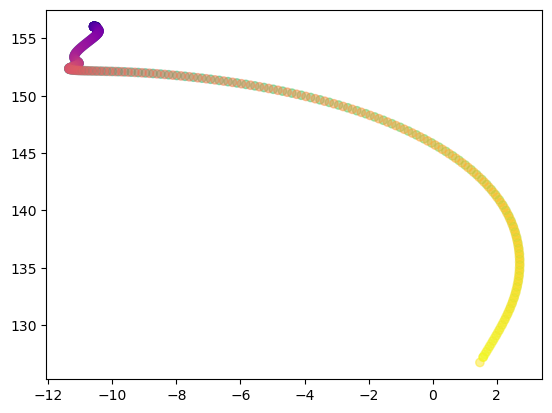

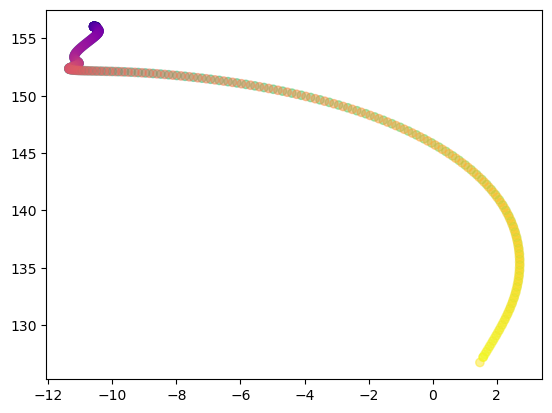

In [13]:
play_num = 12
player_position = 6

fig, ax = plt.subplots()


this_play_players = smoothed_player_pos[(smoothed_player_pos["play_id"] == play_num) & 
                                        (smoothed_player_pos["player_position"] == player_position)]

ax.scatter(this_play_players["field_x"], this_play_players["field_y"], 
           c = this_play_players["timestamp"],
           cmap='viridis',
           alpha = 0.5
          )

ax.scatter(this_play_players["smoothed_field_x"], this_play_players["smoothed_field_y"], 
           c = this_play_players["timestamp"],
           cmap='plasma',
           alpha = 0.5
          )

fig

I think the answer here is that is doesn't matter if you smooth players, they are already pretty smooth

### What if I smooth the ball position?

- My sense is that if I were doing pitching stuff, this would be too aggressive
- Needs to happen after the interp, but before computing velos
- I think I need to just handle the discontinuities so I can have reasonable looking velo vectors

In [14]:
smoothed_ball_pos = ball_pos.copy()

smoothed_xy = ball_pos.groupby(["play_id"])[["ball_position_x", "ball_position_y", "ball_position_z"]]\
    .rolling(3, center=True, closed="both").mean()\
    .loc[:, ["ball_position_x", "ball_position_y", "ball_position_z"]]


smoothed_ball_pos["smoothed_ball_position_x"] = smoothed_xy["ball_position_x"].values
smoothed_ball_pos["smoothed_ball_position_y"] = smoothed_xy["ball_position_y"].values
smoothed_ball_pos["smoothed_ball_position_z"] = smoothed_xy["ball_position_z"].values


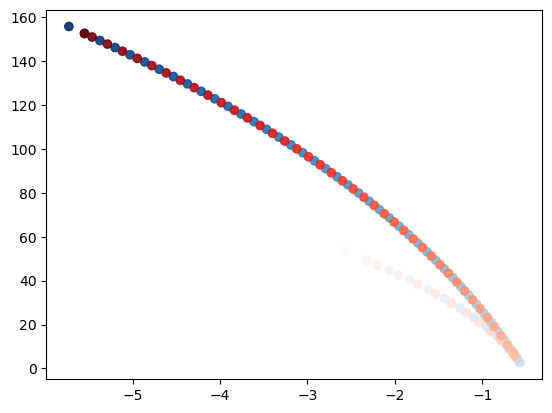

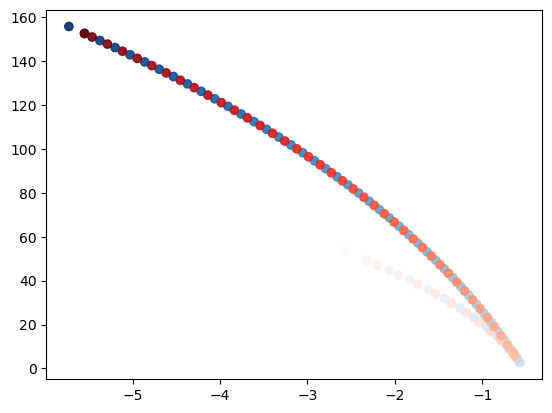

In [15]:
play_num = 12

fig, ax = plt.subplots()

this_play_ball = smoothed_ball_pos[(smoothed_ball_pos["play_id"] == play_num)]

ax.scatter(this_play_ball["ball_position_x"], this_play_ball["ball_position_y"], 
           c = this_play_ball["timestamp"],
           cmap='Blues',
           alpha = 0.9
          )

ax.scatter(this_play_ball["smoothed_ball_position_x"], this_play_ball["smoothed_ball_position_y"], 
           c = this_play_ball["timestamp"],
           cmap='Reds',
           alpha = 0.9
          )

fig

I think this fixed the most obvious discontinuities, but it wrecks the pitch a little bit?

And the problem with play 10 here is that the second baseman I think marked in the wrong position from second (which I would imagine he is actually standing at)

Assumption is being made here, but I am comfortable with this outcome tbh -- 

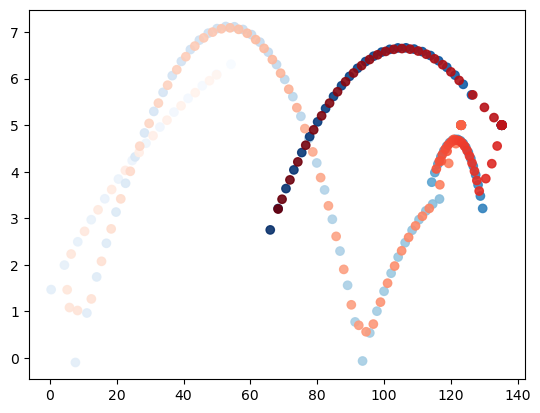

In [16]:
play_num = 10

fig, ax = plt.subplots()

this_play_ball = bf.game_obj.get_this_play(play_num, "ball_pos")

ax.scatter(this_play_ball["ball_position_y"], this_play_ball["ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Blues',
           alpha = 0.9
          )

ax.scatter(this_play_ball["smoothed_ball_position_y"], this_play_ball["smoothed_ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Reds',
           alpha = 0.9
          )

#fig

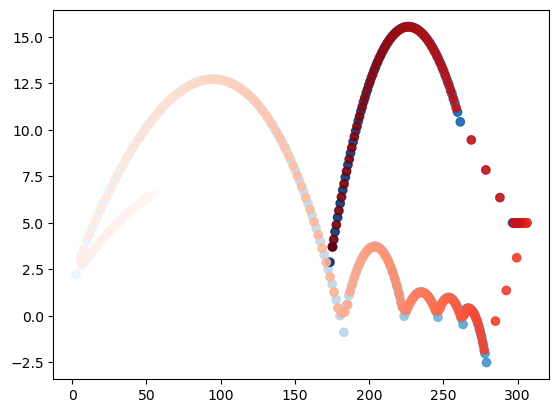

In [17]:
play_num = 162

fig, ax = plt.subplots()

this_play_ball = bf.game_obj.get_this_play(play_num, "ball_pos")

ax.scatter(this_play_ball["ball_position_y"], this_play_ball["ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Blues',
           alpha = 0.9
          )

ax.scatter(this_play_ball["smoothed_ball_position_y"], this_play_ball["smoothed_ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Reds',
           alpha = 0.9
          )

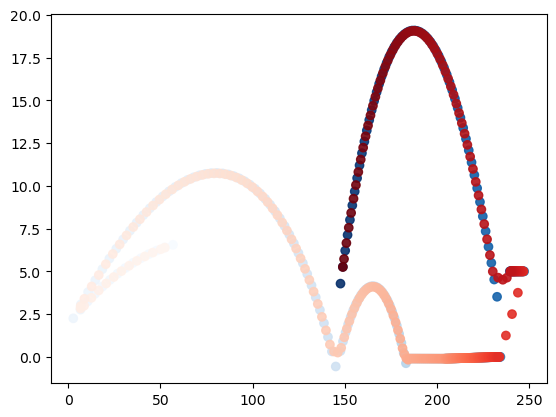

In [18]:
play_num = 204

fig, ax = plt.subplots()

this_play_ball = bf.game_obj.get_this_play(play_num, "ball_pos")

ax.scatter(this_play_ball["ball_position_y"], this_play_ball["ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Blues',
           alpha = 0.9
          )

ax.scatter(this_play_ball["smoothed_ball_position_y"], this_play_ball["smoothed_ball_position_z"], 
           c = this_play_ball["timestamp"],
           cmap='Reds',
           alpha = 0.9
          )

Ok this is a really confusing set of figures, but what I am seeing here is that the smoothing of the ball kills the points where it maybe hits the ground.

I am actually thinking this may become a problem later on, because that information might be important?